In [1]:
import torch
import numpy as np
import pandas as pd
pd.set_option("display.width", 380)
pd.set_option('max_colwidth', 100)

from IPython.display import display

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# Load the sentences

In [2]:
df_train = pd.read_csv("./sick_train/SICK_train.txt", sep="\t")
df_train = df_train.drop(['relatedness_score'], axis=1)

df_dev = pd.read_csv("./sick_trial/SICK_trial.txt", sep="\t")
df_dev = df_dev.drop(['relatedness_score'], axis=1)

df_test = pd.read_csv("./sick_test/SICK_test.txt", sep="\t")
df_test = df_test.drop(['relatedness_score'], axis=1)

In [3]:
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader

In [4]:
from gensim import corpora

In [5]:
class SickDataset(Dataset):
    endOfSentence   = '</s>'
    startOfSentence = '<s>'
    separator2Sentences = '<sep>'
    
    text_label = ["NEUTRAL", "ENTAILMENT", "CONTRADICTION"]
    
    tokens = [startOfSentence, separator2Sentences, endOfSentence]
    
    def join_sentence(self, row):
        """
        Create a new sentence (<s> + s_A + <sep> + s_B + </s>)
        """
        sentence_a = row['sentence_A'].split(" ")
        sentence_b = row['sentence_B'].split(" ")
        return np.concatenate((
            [self.startOfSentence],
            sentence_a,
            [self.separator2Sentences],
            sentence_b,
            [self.endOfSentence]
        ))
    
    def series_text_2_labelID(self, series, keep_n=1000):
        """
        Convert text Label into label id
        """
        reverse_dict = {v: k for k, v in  dict(enumerate(self.text_label)).items()}
        return series.map(reverse_dict)
    
    def series_2_dict(self, series, keep_n):
        """
        Convert document (a list of words) into a list of indexes
        AND apply some filter on the documents
        """
        dictionary = corpora.Dictionary(series)
        dictionary.filter_extremes(
            no_below=1,
            no_above=1,
            keep_n=keep_n,
            keep_tokens=self.tokens)
        return dictionary
    
    
    def __init__(self, df, vocabulary_size, dic = None):
        # Label text as ids
        df["entailment_id"] = self.series_text_2_labelID(df['entailment_judgment'])
        
        # Add <s>,</s>,<sep> tokens to the vocabulary
        df['sentence_AB'] = df.apply(self.join_sentence, axis=1)
        
        # check if the dictionary is given
        if dic is None:
            # Create the Dictionary
            self.dictionary = self.series_2_dict(df['sentence_AB'], vocabulary_size)
        else:
            self.dictionary = dic
        
        # sentence of words -> array of idx
        # Adds unknown to the voc (idx = vocabulary_size), Dictionary size = vocabulary_size+1
        df["word_idx"] = df["sentence_AB"].apply(
            lambda x: np.array(self.dictionary.doc2idx(x, unknown_word_index=vocabulary_size))
        )
        
        self.df = df
        
    def getRef(self, index):
        return self.df['sentence_AB'][index]
        
    def __getitem__(self, index):
        return (
            self.df['word_idx'][index],
            self.df['entailment_id'][index])
    
    def getDictionary(self):
        return self.dictionary
    
    def __len__(self):
        return len(self.df)

vocabulary_size = 1000
sick_dataset_train = SickDataset(df_train, vocabulary_size)
sick_dataset_train.df.head()

,pair_ID,sentence_A,sentence_B,entailment_judgment,entailment_id,sentence_AB,word_idx
0,1,A group of kids is playing in a yard and an old man is standing in the background,A group of boys in a yard is playing and a man is standing in the background,NEUTRAL,0,"[<s>, A, group, of, kids, is, playing, in, a, yard, and, an, old, man, is, standing, in, the, ba...","[1, 3, 9, 14, 12, 11, 16, 10, 4, 19, 6, 5, 15, 13, 11, 17, 10, 18, 7, 2, 3, 9, 14, 8, 10, 4, 19,..."
1,2,A group of children is playing in the house and there is no man standing in the background,A group of kids is playing in a yard and an old man is standing in the background,NEUTRAL,0,"[<s>, A, group, of, children, is, playing, in, the, house, and, there, is, no, man, standing, in...","[1, 3, 9, 14, 20, 11, 16, 10, 18, 21, 6, 23, 11, 22, 13, 17, 10, 18, 7, 2, 3, 9, 14, 12, 11, 16,..."
2,3,The young boys are playing outdoors and the man is smiling nearby,The kids are playing outdoors near a man with a smile,ENTAILMENT,1,"[<s>, The, young, boys, are, playing, outdoors, and, the, man, is, smiling, nearby, <sep>, The, ...","[1, 24, 31, 8, 25, 16, 27, 6, 18, 13, 11, 29, 1000, 2, 24, 12, 25, 16, 27, 26, 4, 13, 30, 4, 28, 0]"
3,5,The kids are playing outdoors near a man with a smile,A group of kids is playing in a yard and an old man is standing in the background,NEUTRAL,0,"[<s>, The, kids, are, playing, outdoors, near, a, man, with, a, smile, <sep>, A, group, of, kids...","[1, 24, 12, 25, 16, 27, 26, 4, 13, 30, 4, 28, 2, 3, 9, 14, 12, 11, 16, 10, 4, 19, 6, 5, 15, 13, ..."
4,9,The young boys are playing outdoors and the man is smiling nearby,A group of kids is playing in a yard and an old man is standing in the background,NEUTRAL,0,"[<s>, The, young, boys, are, playing, outdoors, and, the, man, is, smiling, nearby, <sep>, A, gr...","[1, 24, 31, 8, 25, 16, 27, 6, 18, 13, 11, 29, 1000, 2, 3, 9, 14, 12, 11, 16, 10, 4, 19, 6, 5, 15..."


In [6]:
# Create the dev dataset
dictionary_train = sick_dataset_train.getDictionary()
print(dictionary_train)
vocabulary_size = len(dictionary_train)

sick_dataset_dev = SickDataset(df_dev, vocabulary_size, dictionary_train)
dictionary_dev = sick_dataset_dev.getDictionary()
print(dictionary_dev)
sick_dataset_dev.df.head()

Dictionary(1000 unique tokens: ['', 'sauce', 'floor', 'okra', 'bike']...)
Dictionary(1000 unique tokens: ['', 'sauce', 'floor', 'okra', 'bike']...)


,pair_ID,sentence_A,sentence_B,entailment_judgment,entailment_id,sentence_AB,word_idx
0,4,The young boys are playing outdoors and the man is smiling nearby,There is no boy playing outdoors and there is no man smiling,CONTRADICTION,2,"[<s>, The, young, boys, are, playing, outdoors, and, the, man, is, smiling, nearby, <sep>, There...","[1, 24, 31, 8, 25, 16, 27, 6, 18, 13, 11, 29, 1000, 2, 101, 11, 22, 149, 16, 27, 6, 23, 11, 22, ..."
1,24,A person in a black jacket is doing tricks on a motorbike,A skilled person is riding a bicycle on one wheel,NEUTRAL,0,"[<s>, A, person, in, a, black, jacket, is, doing, tricks, on, a, motorbike, <sep>, A, skilled, p...","[1, 3, 50, 10, 4, 44, 46, 11, 45, 52, 48, 4, 47, 2, 3, 1000, 50, 11, 51, 4, 43, 48, 49, 53, 0]"
2,105,Four children are doing backbends in the gym,Four girls are doing backbends and playing outdoors,NEUTRAL,0,"[<s>, Four, children, are, doing, backbends, in, the, gym, <sep>, Four, girls, are, doing, backb...","[1, 107, 20, 25, 45, 1000, 10, 18, 109, 2, 107, 111, 25, 45, 1000, 6, 16, 27, 0]"
3,116,A player is throwing the ball,Two teams are competing in a football match,NEUTRAL,0,"[<s>, A, player, is, throwing, the, ball, <sep>, Two, teams, are, competing, in, a, football, ma...","[1, 3, 65, 11, 597, 18, 55, 2, 32, 118, 25, 117, 10, 4, 115, 1000, 0]"
4,119,Five children are standing in front of a wooden hut,Five children are standing in a wooden hut,NEUTRAL,0,"[<s>, Five, children, are, standing, in, front, of, a, wooden, hut, <sep>, Five, children, are, ...","[1, 119, 20, 25, 17, 10, 40, 14, 4, 121, 1000, 2, 119, 20, 25, 17, 10, 4, 121, 1000, 0]"


In [7]:
# Create the test dataset

sick_dataset_test = SickDataset(df_test, vocabulary_size, dictionary_train)
dictionary_test = sick_dataset_test.getDictionary()
print(dictionary_test)
sick_dataset_test.df.head()

Dictionary(1000 unique tokens: ['', 'sauce', 'floor', 'okra', 'bike']...)


,pair_ID,sentence_A,sentence_B,entailment_judgment,entailment_id,sentence_AB,word_idx
0,6,There is no boy playing outdoors and there is no man smiling,A group of kids is playing in a yard and an old man is standing in the background,NEUTRAL,0,"[<s>, There, is, no, boy, playing, outdoors, and, there, is, no, man, smiling, <sep>, A, group, ...","[1, 101, 11, 22, 149, 16, 27, 6, 23, 11, 22, 13, 29, 2, 3, 9, 14, 12, 11, 16, 10, 4, 19, 6, 5, 1..."
1,7,A group of boys in a yard is playing and a man is standing in the background,The young boys are playing outdoors and the man is smiling nearby,NEUTRAL,0,"[<s>, A, group, of, boys, in, a, yard, is, playing, and, a, man, is, standing, in, the, backgrou...","[1, 3, 9, 14, 8, 10, 4, 19, 11, 16, 6, 4, 13, 11, 17, 10, 18, 7, 2, 24, 31, 8, 25, 16, 27, 6, 18..."
2,8,A group of children is playing in the house and there is no man standing in the background,The young boys are playing outdoors and the man is smiling nearby,NEUTRAL,0,"[<s>, A, group, of, children, is, playing, in, the, house, and, there, is, no, man, standing, in...","[1, 3, 9, 14, 20, 11, 16, 10, 18, 21, 6, 23, 11, 22, 13, 17, 10, 18, 7, 2, 24, 31, 8, 25, 16, 27..."
3,10,A brown dog is attacking another animal in front of the tall man in pants,A brown dog is attacking another animal in front of the man in pants,ENTAILMENT,1,"[<s>, A, brown, dog, is, attacking, another, animal, in, front, of, the, tall, man, in, pants, <...","[1, 3, 38, 39, 11, 1000, 37, 36, 10, 40, 14, 18, 269, 13, 10, 41, 2, 3, 38, 39, 11, 1000, 37, 36..."
4,11,A brown dog is attacking another animal in front of the man in pants,A brown dog is helping another animal in front of the man in pants,NEUTRAL,0,"[<s>, A, brown, dog, is, attacking, another, animal, in, front, of, the, man, in, pants, <sep>, ...","[1, 3, 38, 39, 11, 1000, 37, 36, 10, 40, 14, 18, 13, 10, 41, 2, 3, 38, 39, 11, 1000, 37, 36, 10,..."


In [8]:
pd.DataFrame(list(zip(sick_dataset_train.getRef(2), sick_dataset_train[2][0]))).T

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,<s>,The,young,boys,are,playing,outdoors,and,the,man,...,are,playing,outdoors,near,a,man,with,a,smile,</s>
1,1,24,31,8,25,16,27,6,18,13,...,25,16,27,26,4,13,30,4,28,0


# Create the RNN Model

In [9]:
from torch import nn

In [10]:
class RNNClassifier(nn.Module):
    # Our model

    def __init__(self, input_voc_size, embedding_size, hidden_size):
        super(RNNClassifier, self).__init__()
        
        self.input_voc_size = input_voc_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        
        self.num_classes = 3
        
        # Add the unknown token
        self.embedding = nn.Embedding(input_voc_size+1, embedding_size)
        self.rnn = nn.RNN(
              input_size=embedding_size,
              hidden_size=hidden_size,
              batch_first=True)
        self.fc = nn.Linear(hidden_size, self.num_classes)
        
    def forward(self, x):
        # Initialize hidden and cell states
        # (num_layers * num_directions, batch, hidden_size)
        h_0 = torch.zeros(1, 1, self.hidden_size).to(device)
        # When creating new variables inside a model (like the hidden state in an RNN/GRU/LSTM),
        # make sure to also move them to the device (GPU).

        emb = self.embedding(x)
        emb = emb.view(1, x.size(0), -1)

        # Propagate embedding through RNN
        # Input: (batch, seq_len, embedding_size)
        # h_0: (num_layers * num_directions, batch, hidden_size)
        out, hidden = self.rnn(emb, h_0)
        
        # Fully connected layers
        out = self.fc(hidden)
        return out
    
rnn = RNNClassifier(vocabulary_size, 100, 10)
rnn.to(device)
print(rnn)

# Set loss and optimizer function
# CrossEntropyLoss = LogSoftmax + NLLLoss
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01)

RNNClassifier(
  (embedding): Embedding(1001, 100)
  (rnn): RNN(100, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=3, bias=True)
)


# Evaluation helpers

In [68]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.metrics import precision_recall_fscore_support

import matplotlib.pyplot as plt
import itertools

def confusion_scores(total_labels, total_pred):
    classes = SickDataset.text_label
    title='Confusion matrix'
    
    cm = confusion_matrix(total_labels, total_pred, labels=[0, 1, 2])
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


def evaluate(model, loader):
    model.eval()
    with torch.no_grad():
        total_labels = []
        total_pred = []
        for _, (data, target) in enumerate(loader):

                data = data.to(device)
                target = target.to(device)

                idx_sentences = data.view(-1)
                output = rnn(idx_sentences)[0]

                # Get the Accuracy
                _, predicted = torch.max(output.data, dim=1)
                correct = (predicted == target).sum().item()
                
                total_labels.append(list(target.cpu().numpy()))
                total_pred.append(list(predicted.cpu().numpy()))

                
        confusion_scores(total_labels, total_pred)
        
        print("Accuracy:  {:.4f}".format(accuracy_score(total_labels, total_pred)))
        
        # compute per-label precisions, recalls, F1-scores, and supports instead of averaging 
        metrics = precision_recall_fscore_support(
                                        total_labels, total_pred,
                                        average=None, labels=[0, 1, 2])
        
        df = pd.DataFrame(list(metrics), index=['Precision', 'Recall', 'Fscore', 'support'],
                                   columns=SickDataset.text_label)
        df = df.drop(['support'], axis=0)
        display(df.T)
        


# To DataLoader

In [40]:
from torch.utils.data import DataLoader

In [41]:
train_loader = DataLoader(dataset=sick_dataset_train,
                          batch_size=1, shuffle=True)

dev_loader = DataLoader(dataset=sick_dataset_dev,
                          batch_size=1, shuffle=False)

test_loader = DataLoader(dataset=sick_dataset_test,
                          batch_size=1, shuffle=False)

# Training the Model 

In [14]:
%%time
# Train the model
verbose = False

num_epochs=2

rnn.train()
rnn_losses = []

for epoch in range(num_epochs):
    total_correct = 0
    total_target = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        
        data = data.to(device)
        target = target.to(device)
        
        idx_sentences = data.view(-1)
        if verbose:
            print('idx_sentences', idx_sentences.size())
                
        target = target
        if verbose:
            print('target', target)
        
        output = rnn(idx_sentences)[0]
        if verbose:
            print('output', output)
        
        loss = criterion(output, target)
        if verbose:
            print('lose', loss)
        
        rnn.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Get the Accuracy
        _, predicted = torch.max(output.data, dim=1)
        correct = (predicted == target).sum().item()
        
        total_correct += correct
        total_target += target.size(0)
        
        if batch_idx % 100 == 0 or batch_idx % 100 == 1 :
            print('\r Train Epoch: [{}/{}] | Step [{:5}/{} ({:.0f}%)] | Loss: {:.4f} | Accuracy: {:.4f}%'.format(
                    epoch+1, num_epochs,
                    batch_idx * len(data), 
                    len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), 
                    loss.item(), 
                    (total_correct / total_target) * 100), end=' ')
            
    print()


print("Learning finished!")

 Train Epoch: [1/2] | Step [ 4401/4500 (98%)] | Loss: 0.5594 | Accuracy: 54.2481% 
 Train Epoch: [2/2] | Step [ 4401/4500 (98%)] | Loss: 0.7897 | Accuracy: 54.4071% 
Learning finished!
CPU times: user 35.2 s, sys: 1.36 s, total: 36.6 s
Wall time: 36.4 s


# Evaluate the model on dev

Accuracy:  0.5640


,Precision,Recall,Fscore
NEUTRAL,0.564,1.0,0.721228
ENTAILMENT,0.000,0.0,0.000000
CONTRADICTION,0.000,0.0,0.000000


CPU times: user 872 ms, sys: 128 ms, total: 1 s
Wall time: 867 ms


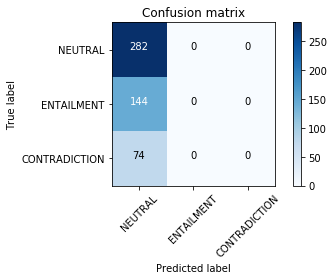

In [69]:
%%time

evaluate(rnn, dev_loader)

# Evaluate the model on test

Accuracy:  0.5669


,Precision,Recall,Fscore
NEUTRAL,0.566876,1.0,0.723575
ENTAILMENT,0.000000,0.0,0.000000
CONTRADICTION,0.000000,0.0,0.000000


CPU times: user 6 s, sys: 216 ms, total: 6.22 s
Wall time: 6.05 s


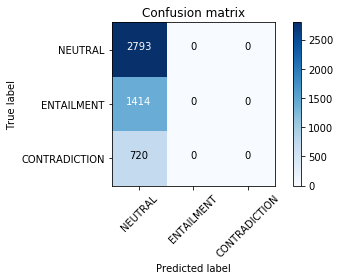

In [70]:
%%time

evaluate(rnn, test_loader)